# Traffic Light Recognition - Scaling the Prototype 
This is a notebook I created to document how I would scale my Traffic Light Recognition prototype, with the aim to 'productionize' the model.
In this project, I'm attempting to build a complete end to end traffic light detection and recognition system, using the LISA Traffic Light dataset. 

In my [prototype notebook](https://github.com/aidandunlop/traffic-lights/blob/master/prototype/prototype.ipynb), I use [pytorch](https://pytorch.org/) to fine tune a pretrained Faster_RCNN model (`fasterrcnn_resnet50_fpn` - trained on the ImageNet database), on the [LISA Traffic Light Dataset](https://www.kaggle.com/mbornoe/lisa-traffic-light-dataset). Due to the amount of images in the dataset and the training time, I only used a subset of the data in the prototype, and found optimal hyperparameters with that dataset. In this notebook, I'll use those hyperparameters to train on the full dataset.

Ideally I'd perform hyperparameter optimization on the full dataset, but have decided not to due to time and cost limitations. At the bottom of this notebook I've described how I would fully scale this DL pipeline given unlimited time and cost resources.

## Setup

The setup step is essentially the same as in the prototype notebook.
First let's import the dependencies we need.

In [1]:
import os, sys, glob
import pandas as pd
import numpy as np
import cv2
import torch
import torch.utils.data
import torchvision
import random
import shutil
import math
import time
from PIL import Image
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# import helper functions from pytorch
from engine import train_one_epoch
import engine_utils

# import evaluation library from https://github.com/rafaelpadilla/Object-Detection-Metrics 
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import Evaluator

# import Ax 
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

Next let's store the path to the dataset, so we can reuse it later.

In [2]:
dataset_path = '/notebooks/traffic-lights/lisa-traffic-light-dataset'

The annotations for each image are stored in multiple csv files, so let's write a quick function to convert them into a Pandas DataFrame:

In [3]:
def createDataFrame(files):
    df = pd.concat((pd.read_csv(f, ';') for f in files))
    return df

As our dataset is very large, we're going to have to load the data in batches, so let's extend the pytorch [Dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets) class for our dataset. This will be passed to a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which will allow us to iterate over the dataset efficiently.

In [4]:
# Define class labels
CLASS_LABEL_MAP = {
    'go': 1,
    'goForward': 2,
    'goLeft': 3,
    "warning": 4,
    "warningLeft": 5,
    "stop": 6,
    "stopLeft": 7
}

class LISADataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, bad_images=[]):
        self.root = root
        self.transforms = transforms

        # load all annotation files
        annotationFiles = glob.glob(os.path.join(root, 'Annotations/Annotations', '**/*BOX.csv'), recursive=True)
        self.annotations = createDataFrame(annotationFiles)
        # only load images with associated annotations (i.e. traffic lights). Pytorch's API doesn't accept negative training images.         
        self.imgs = self.annotations['Filename'].str.split('/').str[-1].unique()
        # filter out bad images if there are any
        self.imgs = [img for img in self.imgs if img not in bad_images]
        self.annotations = self.annotations[~self.annotations['Filename'].str.split('/').str[-1].isin(bad_images)]

    # get traffic light annotations for a given frame
    def getBoxAnnotationsForFrame(self, frame_id):
        stripped_filename = self.annotations['Filename'].str.split('/').str[-1]
        annotations = self.annotations.loc[stripped_filename == frame_id]
        return annotations[['Filename', 'Annotation tag', 'Upper left corner X', 'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y']]

    def __getitem__(self, idx):
        # load image at that index
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        annotation = self.getBoxAnnotationsForFrame(self.imgs[idx])
        # get bounding box coordinates for each traffic light
        num_objs = len(annotation)
        boxes = []
        labels = []
        for index, row in annotation.iterrows():
            xmin = row['Upper left corner X']
            xmax = row['Lower right corner X']
            ymin = row['Upper left corner Y']
            ymax = row['Lower right corner Y']
            boxes.append([xmin, ymin, xmax, ymax])
            tag = CLASS_LABEL_MAP[row['Annotation tag']]
            labels.append(CLASS_LABEL_MAP[row['Annotation tag']])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        # calculate the area for the bounding boxes         
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if num_objs > 0 else 0
        area = torch.as_tensor(area, dtype=torch.float32)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        img_name = self.imgs[idx]

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target, img_name

    def __len__(self):
        return len(self.imgs)
    
    def get_height_and_width(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        width, height = Image.open(img_path).size
        return height, width

We might want to transform our images during the training phase to improve the accuracy of our system. To begin with, we won't be applying any additional transforms, but let's set this up in case we want to later.

We can do so by writing a `get_transform` function that is run on each image during processing.

In [5]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

We're going to want to run this on a GPU, to speed up processing times. It can be run on a CPU, but will take too long.

In [6]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Splitting the dataset

We're going to split the dataset as before, but as we're using the hyperparameters we found in the prototype, we won't need to take a validation subset. This also means we'll have more data to train with.

In [7]:
# Load the dataset. Remove any bad images (found in the prototype notebook)
full_dataset = LISADataset(dataset_path, transforms=get_transform(), bad_images=['nightClip3--00172.jpg'])
print('Number of images:', len(full_dataset))
print('Number of annotations (i.e. number of annotated traffic lights):', len(full_dataset.annotations))
print('Class counts:')
print(full_dataset.annotations['Annotation tag'].value_counts())


Number of images: 36264
Number of annotations (i.e. number of annotated traffic lights): 109473
Class counts:
go             46723
stop           44318
stopLeft       12734
warning         2669
goLeft          2475
warningLeft      349
goForward        205
Name: Annotation tag, dtype: int64


In [8]:
image_paths = full_dataset.annotations.groupby('Filename')

labels_per_image = image_paths.apply(lambda x: x['Annotation tag'].unique())
# find combinations of traffic lights
label_combinations = [[CLASS_LABEL_MAP[label] for label in labels] for labels in labels_per_image]

Pytorch doesn't contain a Stratified Sampler, but we can extend the base sampler class to create our own. The following stratified Sampler was adapted from [torchsample](https://github.com/ncullen93/torchsample). 

In [9]:
# adapted from torchsample
from torch.utils.data import Sampler
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size, test_size=0.5):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = int(class_vector.size(0) / batch_size)
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        # stratification is done on y, so X doesn't matter here
        X = torch.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return (train_index, test_index)

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)


StratifiedShuffleSplit expects each label (in this case the combinations) to be of the same size, so let's pad out the combinations so they are of equal size.

In [10]:
maxLen = max(map(len, label_combinations))
for row in label_combinations:
    while len(row) < maxLen:
        row.append(0)

Here we perform stratified sampling, splitting to get our training and testing sets.
We then create our dataloaders, which we can use to iterate over the data later.

In [11]:
# perform split of dataset into training and testing
training_indices, testing_indices  = list(StratifiedSampler(torch.tensor(label_combinations), 1, test_size=0.3))

In [12]:
# split data into training and testing, with 70:30 ratio 
training_dataset = torch.utils.data.Subset(full_dataset, training_indices)

testing_dataset = torch.utils.data.Subset(full_dataset, testing_indices)

print('Subset sizes')
print('Training: {}, Testing: {}'.format(len(training_dataset), len(testing_dataset)))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    training_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=engine_utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    testing_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=engine_utils.collate_fn)

Subset sizes
Training: 25384, Testing: 10880


Let's see the distribution of classes across the training and testing sets:

In [13]:
df = pd.DataFrame({'filename':labels_per_image.index, 'classes':labels_per_image.values})
train_df = df.take(training_indices)
test_df = df.take(testing_indices)
print('Train:\n{}\n'.format(train_df.classes.explode().value_counts()))
print('Test:\n{}\n'.format(test_df.classes.explode().value_counts()))

Train:
go             13038
stop           13014
stopLeft        7256
goLeft          1311
warning          775
warningLeft      160
goForward        111
Name: classes, dtype: int64

Test:
go             5588
stop           5577
stopLeft       3111
goLeft          562
warning         331
warningLeft      67
goForward        48
Name: classes, dtype: int64



In [14]:
def create_bounding_boxes(data_loader, bb_type, model, ground_truth_bb = None):
    is_detection = bb_type == BBType.Detected
    if is_detection and ground_truth_bb is not None:
        model.eval()
        bounding_boxes = ground_truth_bb
    elif is_detection:
        raise Exception('please provide ground truth bounding boxes.')
    else:
        bounding_boxes = BoundingBoxes()

    for images, targets, image_names in data_loader:
        if is_detection:
            images = list(img.to(device) for img in images)
            annotations = model(images)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        else:
            annotations = [{k: v.to(device) for k, v in t.items()} for t in targets]

        for annotation, image_name in zip(annotations, image_names):
            boxes = annotation['boxes'].tolist()
            labels = annotation['labels'].tolist()
            scores = annotation['scores'].tolist() if 'scores' in annotation else None
            items = zip(boxes, labels, scores) if is_detection else zip(boxes, labels)

            for item in items:
                if is_detection: box, label, score = item
                else: box, label = item

                x1, y1, x2, y2 = box
                bounding_box_args = { 'imageName': image_name, 'classId': label,
                    'x': x1, 'y': y1, 'w': x2, 'h': y2,
                    'typeCoordinates': CoordinatesType.Absolute,
                    'bbType': bb_type, 'format': BBFormat.XYX2Y2
                }
                if is_detection: bounding_box_args['classConfidence'] = score
                bb = BoundingBox(**bounding_box_args)
                bounding_boxes.addBoundingBox(bb)

    return bounding_boxes

We create a `get_model` function which returns our pretrained model, which could easily be swapped if needed later.

In [15]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    print('gm', type(model))
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

Let's create our training function, which will train the model given a set of parameters.

In [16]:
num_classes = len(CLASS_LABEL_MAP) + 1

def train(parameterization):
        model = get_model(num_classes)
        model.to(device)
        epochs = parameterization['num_epochs']
        learning_rate = parameterization['lr']
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        print('Using lr={} and num_epochs={}'.format(learning_rate, epochs))
        for epoch in range(epochs):
            train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
        torch.save(model, 'model_lr_{}_epochs_{}.pth'.format(learning_rate, epochs))
        torch.save(model, '/artifacts/model_lr_{}_epochs_{}.pth'.format(learning_rate, epochs))
        # torch.save(model.state_dict(), 'model_lr_{}_epochs_{}.pth'.format(learning_rate, epochs))
        # torch.save(model.state_dict(), '/artifacts/model_lr_{}_epochs_{}.pth'.format(learning_rate, epochs))
        
        return model

The best parameters I found were a learning rate of 6.863259765402522e-06, with 2 epochs. I'm sure I can find better, but let's see how well that does for now.

This will take a long time. I'd like to speed it up with parallel processing in the future. For the time being, I'm using `papermill` to run this notebook in the background.

In [17]:
best_params = {'lr': 0.000453864935942075, 'num_epochs': 4}
model = train(best_params)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



gm <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
Using lr=0.000453864935942075 and num_epochs=4


/pytorch/torch/csrc/utils/python_arg_parser.cpp:749: UserWarning:

This overload of nonzero is deprecated:
	nonzero(Tensor input, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, bool as_tuple)



Epoch: [0]  [    0/12692]  eta: 7:03:22  lr: 0.000454  time: 2.0015  data: 1.1995  max mem: 2138
Epoch: [0]  [ 1000/12692]  eta: 3:21:37  lr: 0.000454  time: 1.0339  data: 0.0095  max mem: 2562
Epoch: [0]  [ 2000/12692]  eta: 3:04:13  lr: 0.000454  time: 1.0322  data: 0.0094  max mem: 2562
Epoch: [0]  [ 3000/12692]  eta: 2:46:50  lr: 0.000454  time: 1.0332  data: 0.0101  max mem: 2562
Epoch: [0]  [ 4000/12692]  eta: 2:29:31  lr: 0.000454  time: 1.0297  data: 0.0098  max mem: 2562
Epoch: [0]  [ 5000/12692]  eta: 2:12:17  lr: 0.000454  time: 1.0319  data: 0.0103  max mem: 2562
Epoch: [0]  [ 6000/12692]  eta: 1:55:03  lr: 0.000454  time: 1.0317  data: 0.0101  max mem: 2562
Epoch: [0]  [ 7000/12692]  eta: 1:37:52  lr: 0.000454  time: 1.0311  data: 0.0104  max mem: 2562
Epoch: [0]  [ 8000/12692]  eta: 1:20:40  lr: 0.000454  time: 1.0322  data: 0.0099  max mem: 2562
Epoch: [0]  [ 9000/12692]  eta: 1:03:28  lr: 0.000454  time: 1.0302  data: 0.0101  max mem: 2562
Epoch: [0]  [10000/12692]  eta

## Evaluation

Now that we've trained our model, we'll want to evaluate it's performance on our test set. 

We create an `evaluate` function, which given a dataloader, will return the metrics for that particular dataset.

In [18]:
def evaluate(model, data_loader, device, ground_truth_bb):
    all_bb = create_bounding_boxes(data_loader, BBType.Detected, model, ground_truth_bb)
    
    evaluator = Evaluator()
    metrics = evaluator.GetPascalVOCMetrics(all_bb)
    print('Average precision per class:')
    for metric in metrics:
        c = metric['class']
        # Get metric values per each class
        average_precision = metric['AP']
        # Print AP per class
        print('%s: %f' % (c, average_precision))
    return metrics

Let's define some helper functions to visualize the predictions on a test image:

In [19]:
colourMap = {
    'go': (0, 255, 0), 
    'goForward': (0, 255, 0), 
    'goLeft': (0, 255, 0), 
    'warning': (255, 127, 0), 
    'warningLeft': (255, 127, 0), 
    'stop': ( 255, 0, 0), 
    'stopLeft': ( 255, 0, 0)
}

REVERSED_CLASS_LABEL_MAP = dict((reversed(item) for item in CLASS_LABEL_MAP.items()))

def get_prediction(img, model, threshold):
    pred = model([img.to(device)])
    print(type(model))
    pred_class = [REVERSED_CLASS_LABEL_MAP[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())]
    pred_score = list(pred[0]['scores'].cpu().detach().numpy())
    print('predicted labels:', pred_class)
    print('predicted scores:', pred[0]['scores'].tolist())
    accepted_scores = [pred_score.index(x) for x in pred_score if x > threshold]
    if len(accepted_scores) <= 0:
        return ([],[])
    
    pred_t = accepted_scores[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

def plot_detection(image, model, threshold=0.5, rect_th=1, text_size=1, text_th=2):
    boxes, pred_cls = get_prediction(image, model, threshold) # Get predictions
    img = image.permute(1, 2, 0).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box, classname in zip(boxes,pred_cls):
        min_coord = tuple(map(int, box[0]))
        max_coord = tuple(map(int, box[1]))
        light_color = colourMap[classname]
        text_location = (min_coord[0], min_coord[1] - 10)

        cv2.rectangle(img, min_coord, max_coord, light_color, rect_th)
        cv2.putText(img, classname, text_location, cv2.FONT_HERSHEY_SIMPLEX, text_size, light_color, thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

We'll now visualize the performance of our model on some random test images, and evaluate the performance on the test dataset as a whole. We'll use a confidence score threshold of 80%, so any objects that were detected with lower confidence than 80% won't be shown.

showing detection for nightSequence1--04216.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
predicted labels: ['go', 'go', 'go', 'stop', 'stop', 'stopLeft']
predicted scores: [0.9924628734588623, 0.9906209707260132, 0.9743897318840027, 0.5225391983985901, 0.5210551023483276, 0.15728163719177246]


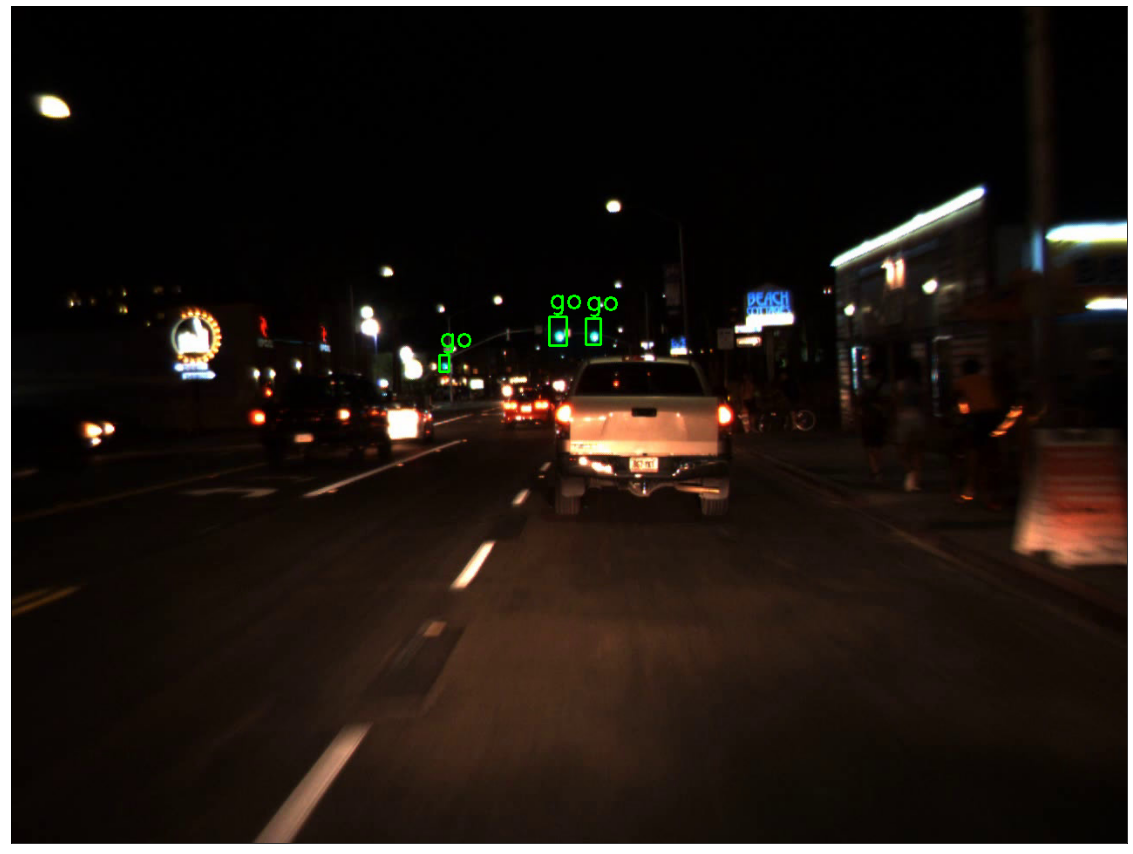

showing detection for nightSequence2--03451.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
predicted labels: ['stop', 'stop', 'stop', 'stop', 'go', 'stopLeft']
predicted scores: [0.9964169263839722, 0.9888806343078613, 0.8724703788757324, 0.363686740398407, 0.05393065884709358, 0.051542188972234726]


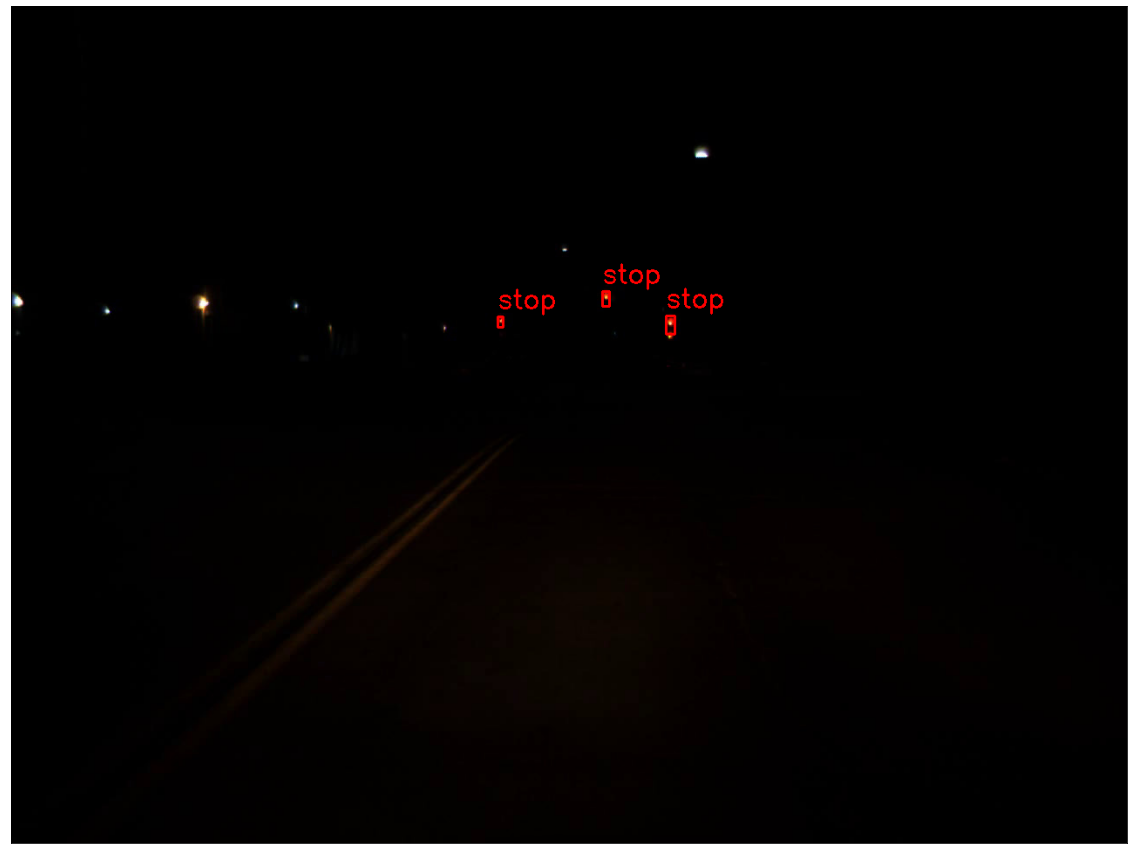

showing detection for nightSequence1--00101.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
predicted labels: ['stop', 'go', 'go', 'stop', 'warning', 'warning', 'stop']
predicted scores: [0.9975035786628723, 0.9827843904495239, 0.9799291491508484, 0.6118583679199219, 0.2995416820049286, 0.2688692808151245, 0.0927475243806839]


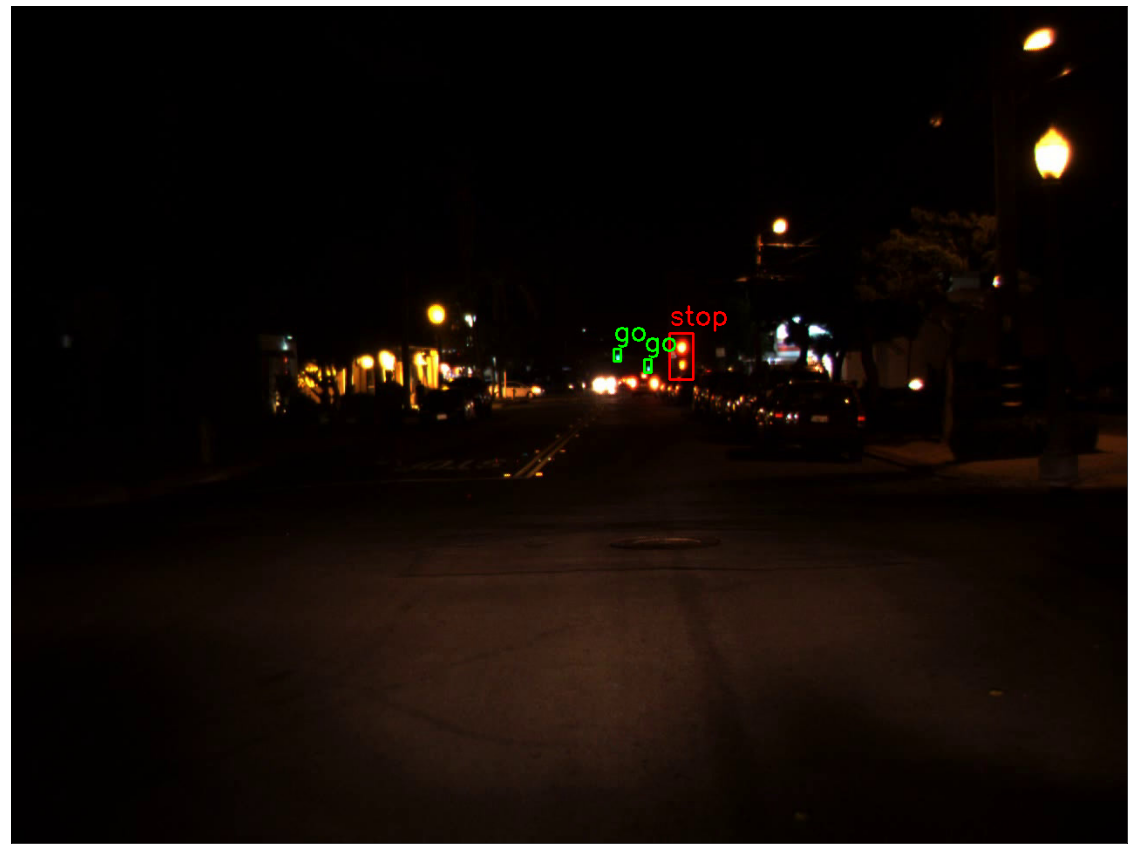

showing detection for dayClip5--02493.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
predicted labels: ['stopLeft', 'go', 'go', 'go', 'go']
predicted scores: [0.9982494115829468, 0.9972471594810486, 0.9971042275428772, 0.9941417574882507, 0.9925907850265503]


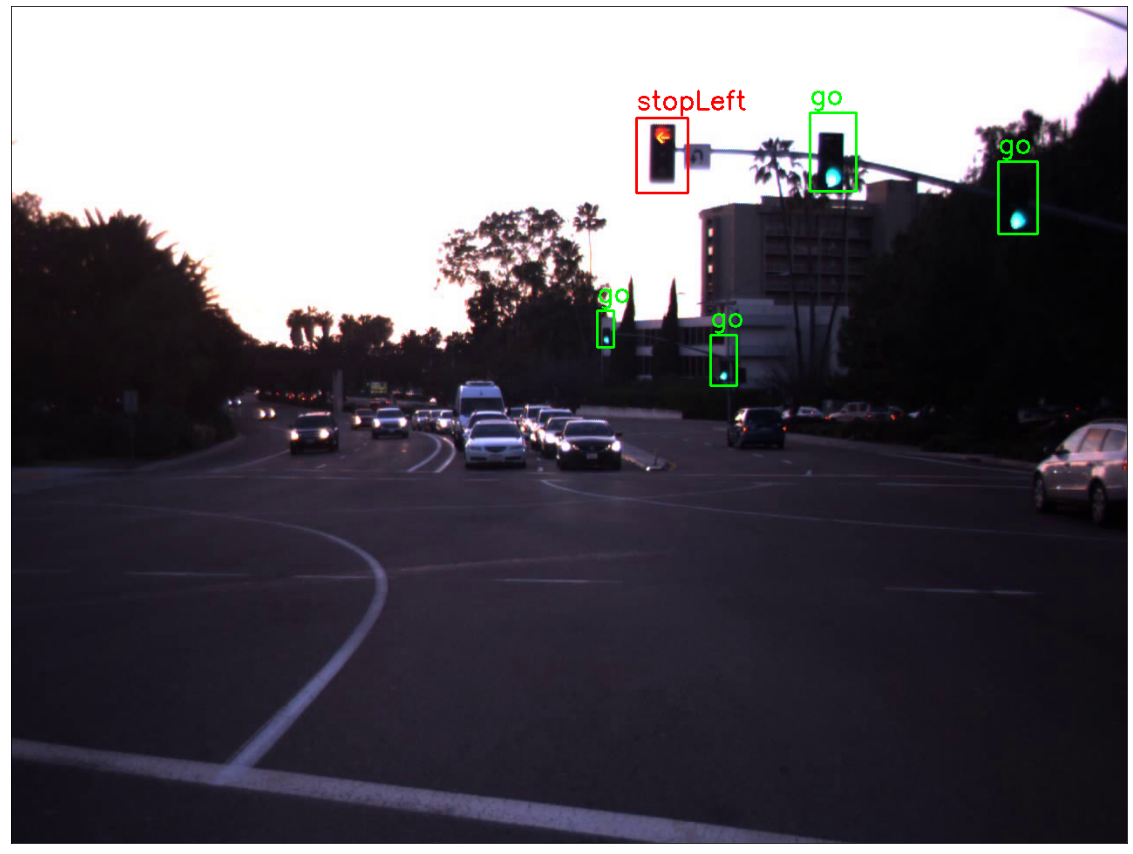

showing detection for nightClip2--01916.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
predicted labels: ['go', 'goLeft', 'go', 'go', 'goForward', 'stopLeft', 'go']
predicted scores: [0.9960747957229614, 0.9594720005989075, 0.9083211421966553, 0.2448415607213974, 0.06026559695601463, 0.05465983226895332, 0.05369172245264053]


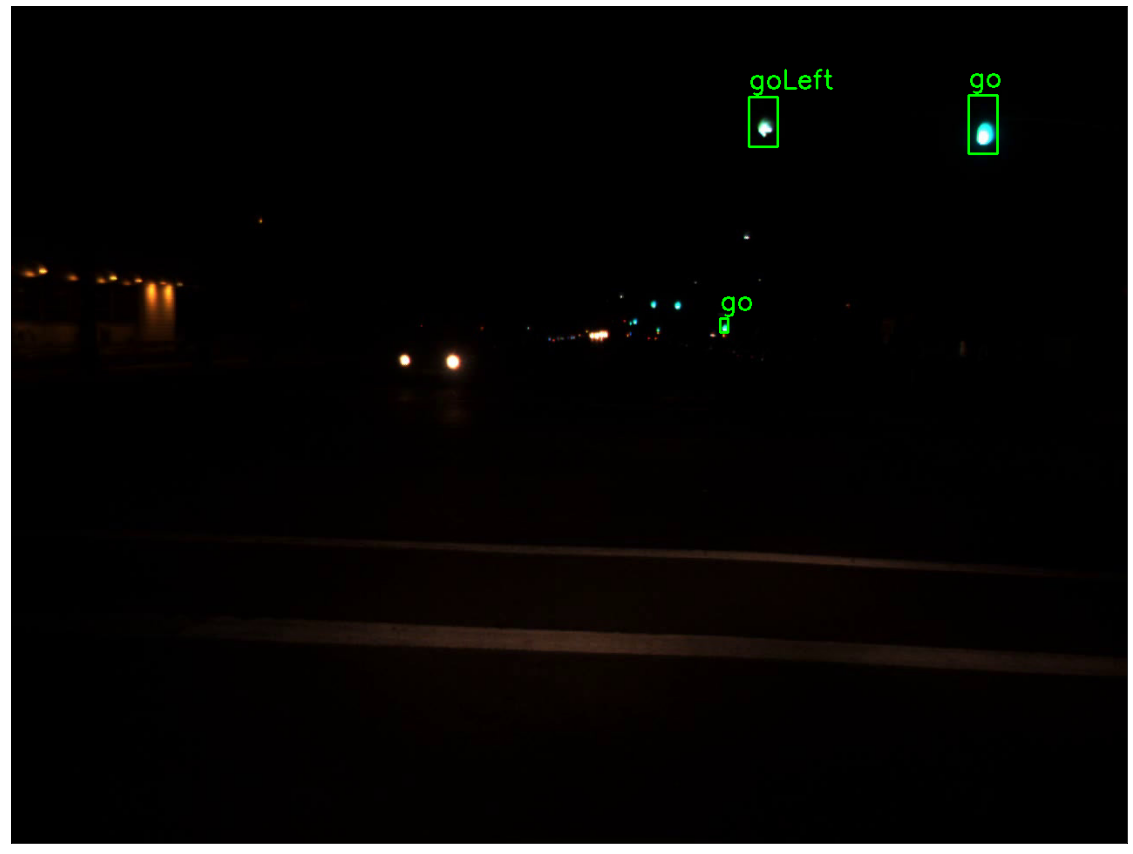

In [20]:
path_to_best_model = 'model_lr_{}_epochs_{}.pth'.format(best_params['lr'], best_params['num_epochs'])
print(path_to_best_model)

images_path = os.path.join(dataset_path, 'images')

if os.path.exists(path_to_best_model):
    model = torch.load(path_to_best_model)
    model.eval()
    data_iterator = iter(data_loader_test)
    for i in range(5):        
        image, label, filename = [ x[0] for x in next(data_iterator) ]
        print('showing detection for', filename)
        plot_detection(image, model, 0.8, rect_th=2)


In [21]:
print('creating testing ground truth boxes...')
testing_ground_truth = create_bounding_boxes(data_loader_test, BBType.GroundTruth, model)
# evaluate against test dataset
print('getting evaluation scores...')
evaluation = evaluate(model, data_loader_test, device, testing_ground_truth)

creating testing ground truth boxes...
getting evaluation scores...
Average precision per class:
1: 0.944455
2: 0.565496
3: 0.871407
4: 0.900119
5: 0.685757
6: 0.964187
7: 0.935147


In [22]:
precisions = [0 if np.isnan(metric['AP']) else metric['AP'] for metric in evaluation]
mean_average_precision = np.sum(precisions) / len(CLASS_LABEL_MAP)
print('Mean average precision:', mean_average_precision)

Mean average precision: 0.8380811970131815


83% is pretty good, but can we do better?

## Further scaling

Given more time and money, we could have done a lot more to improve the performance of the model and the speed of the training process.

### Performance
#### Class Distribution
Classes 2 and 5 (`goForward` and `warningLeft`) massively bring down the performance average, presumably because of their lower occurrences in the dataset. I tried weighted sampling, where I used PyTorch's `WeightedRandomSampler` to choose samples from the dataset that resulted in an even class distribution. However, this tended to just overfit the dataset and didn't yield good performance at all. It would be better to improve the class count range by augmenting the data (with filters and transformations) which brought up the count of the lower seen classes. Better yet would be to get real data for the least occurring classes. It's worth noting, that in a real world scenario, the occurrence of a `go` or `stop` traffic light is more common than `goForward` and `warningLeft`.

If we used this model to predict UK traffic lights, we'll probably find that it doesn't perform very well. To fix this, we can do one of two things - make a model location invariant by providing traffic light data from all over the world, which could negatively impact the model's performance, or be location specific, where the model is retrained on a new dataset from a particular location, which takes up more resources.

#### Hyperparameter Tuning
As you saw in the previous notebook, I used `Ax` to efficiently perform hyperparameter tuning. At this scale, hyperparameter tuning requires a lot of resources to do effectively. Ideally I would have chosen a wider range of parameters to pick from, and even utilized tuning algorithms like ASHA, which would hopefully have resulted in a set of hyperparameters that created better results from the model.

### Improving the training process

#### Distributed processing
Training a complex object detection like the one above takes a lot of processing power, and a lot of computation. I trained the model above just using 1 GPU and it took over 14 hours to do so. If we were to do further hyperparameter tuning on the full dataset, this could take weeks. However, if we alter the model slightly using PyTorch's `nn.DataParallel` which will run the operations on multiple GPUs, making the model run parallelly. This could vastly improve the training time and tune the hyperparameters much more quickly. This requires multiple GPUs, which won't be cheap!

We also use pandas to store the annotation files and for easy analysis and extraction. This is pretty efficient for the dataset we have, but if we were to increase the size of the dataset by a few orders of magnitude, we'd want to utilize distributed processing, which we could do with Dask or PySpark.

#### Other architectures
FasterRCNN isn't the only object detection deep learning pipeline - there are others, and they have their advantages and disadvantages. The YOLO detector (now at version 3) is much faster as "you only looks once (hence yolo)", but on average isn't as accurate as FasterRCNN. SSD (single shot detector) is also fast and performs better than YOLO on average.


#### Using RaySGD or other hyperparameter tuning libraries/techniques
Around the time I finished this project, [`RaySGD`](https://ray.readthedocs.io/en/latest/raysgd/raysgd.html) was released, which is a lightweight library for distributed deep learning. This could enable me to utilize PyTorch's `DistributedDataParallel` without too much monitoring, and automatically scale clusters for the training process. 

The next step is deploying my model!